<a href="https://colab.research.google.com/github/Abdullahi247/pytorch-fresh-fruit-classification-fresh-vs-rotten/blob/main/Computer_Vision_Fruit_Freshness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fresh Fruit Classification (Fresh and Rotten)


In [19]:
# All required modules are listed below please do pip install before working with this project
import  torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import kagglehub
import tensorflow as tf
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, datasets
import os
import labelme2coco

In [20]:
# In case you are working with google colab or your cache get stucked
# please uncomment the code block below the restart session and run all again
# !rm -rf ~/.cache/torch/hub
# # !rm -rf ~/.cache/torch/checkpoints
# !pip install -U labelme2coco

In [21]:
# Downloade file from kaggle and remove this path to replace it with yours if you already have the dataset
Model_Path = kagglehub.dataset_download("abdulrafeyyashir/fresh-vs-rotten-fruit-images")
print("Path to dataset files:", Model_Path)

Path to dataset files: /root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4


['Fruit Freshness Dataset', 'README.dataset.txt']
Found 519 images


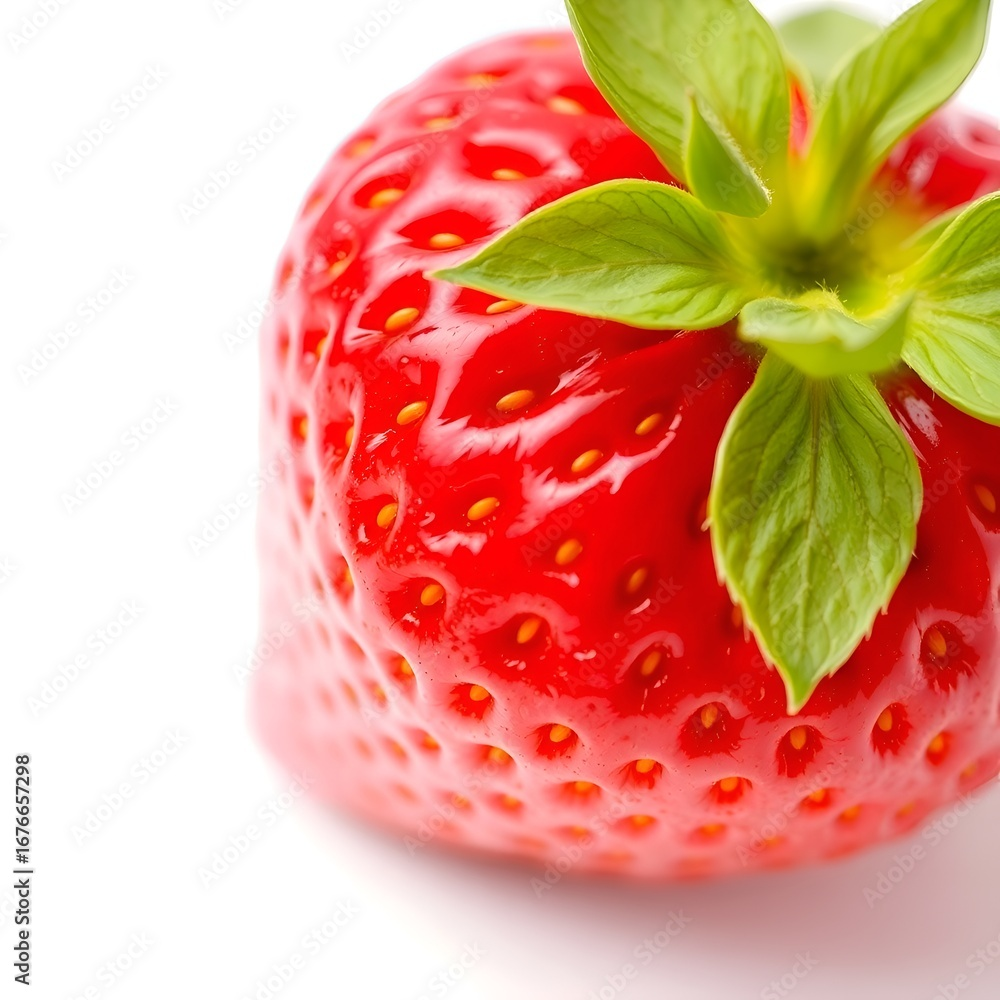

In [22]:
import os, glob, cv2
from google.colab.patches import cv2_imshow

dataset_root = Model_Path

print(os.listdir(dataset_root))

for ext in ('*.jpg','*.jpeg','*.png','*.zip'):
    files = glob.glob(os.path.join(dataset_root, '**', ext), recursive=True)
    if files:
        print('Found', len(files), 'images')

        random_image = np.random.choice(files)
        random_image_index = files.index(random_image)

        img = cv2.imread(files[random_image_index])
        cv2_imshow(img)

        break
else:
    print('No image files found – maybe the dataset is shipped as a single archive?')

In [23]:
# restructure file to match up naming nomenclature

import pathlib
dataset_dir = pathlib.Path(dataset_root + "/" + "Fruit Freshness Dataset/Fruit Freshness Dataset")
dataset_dir

image_paths = list(dataset_dir.glob("*/*/*"))
image_paths = [str(path) for path in image_paths]

print(image_paths[:1])

# extracting labels from path
def parse_path(path):
  parts = tf.strings.split(path, "/")

  fruit = parts[-3]
  freshness = parts[-2]

  return fruit, freshness

# string to integer
fruit_lookup = tf.keras.layers.StringLookup()
freshness_lookup = tf.keras.layers.StringLookup()

fruit_labels = []
freshness_labels = []

for path in image_paths:
  f, fr = parse_path(path)
  fruit_labels.append(f)
  freshness_labels.append(fr)

fruit_lookup.adapt(fruit_labels)
freshness_lookup.adapt(freshness_labels)

print("Fruit classes:", fruit_lookup.get_vocabulary())
print("Freshness classes:", freshness_lookup.get_vocabulary())


['/root/.cache/kagglehub/datasets/abdulrafeyyashir/fresh-vs-rotten-fruit-images/versions/4/Fruit Freshness Dataset/Fruit Freshness Dataset/Apple/Rotten/apple_rotten_001.jpg (46).jpg']
Fruit classes: ['[UNK]', np.str_('Strawberry'), np.str_('Apple'), np.str_('Banana')]
Freshness classes: ['[UNK]', np.str_('Fresh'), np.str_('Rotten')]


In [24]:

from PIL import Image
from torch.utils.data import Dataset

class FruitFreshnessDataset(Dataset):
    def __init__(self, image_paths, fruit_lookup, freshness_lookup, transform=None):
        self.image_paths = image_paths
        self.fruit_lookup = fruit_lookup
        self.freshness_lookup = freshness_lookup
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]

        # Load images (PIL supports jpg/png/webp/jfif)
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Extract labels
        parts = path.split(os.sep)
        fruit = parts[-3]
        freshness = parts[-2]

        fruit_id = self.fruit_lookup[fruit]
        freshness_id = self.freshness_lookup[freshness]

        return image, (fruit_id, freshness_id)


In [104]:
# Adding Tranform to the images and also producing different transform on varyign epoches

# Note that the position you place you transfroms really tell how it will affect it occurence in the epochs
# if GaussianBlur is added at the last line it most likely all your images or 90% of it will be blurred

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [105]:
fruits = sorted(set([p.split(os.sep)[-3] for p in image_paths]))
freshness = sorted(set([p.split(os.sep)[-2] for p in image_paths]))

fruit_to_idx = {f: i for i, f in enumerate(fruits)}
freshness_to_idx = {f: i for i, f in enumerate(freshness)}

num_fruits = len(fruit_to_idx)
num_freshness = len(freshness_to_idx)

In [106]:
from sklearn.model_selection import train_test_split

train_paths, val_paths = train_test_split(
    image_paths, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train size: {len(train_paths)}")
print(f"Validation Size: {len(val_paths)}")

Train size: 452
Validation Size: 114


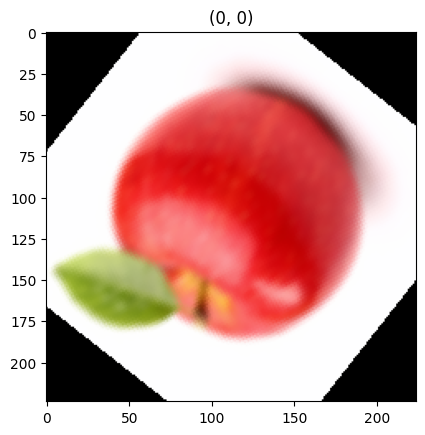

In [114]:
train_ds = FruitFreshnessDataset(
    train_paths, fruit_to_idx, freshness_to_idx, transform
)

val_ds = FruitFreshnessDataset(
    val_paths, fruit_to_idx, freshness_to_idx, transform
)

# Check shown image here
img_tensor, label = train_ds[0]
img = img_tensor.permute(1, 2, 0)
img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
plt.imshow(img.clip(0, 1))
plt.title(label)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)


In [ ]:

class FreshvsRotten(nn.Module):
  def __init__(self, num_classes, output_features):
    super().__init__()

    self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

    for param in self.backbone.parameters():
      param.requires_grad = False

    for param in self.backbone.layer4.parameters():
      param.requires_grad = True

    num_features = self.backbone.fc.in_features
    self.backbone.fc = nn.Identity()


        # Fruit classification head
    self.fruit_classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes)
    )

    # Freshness classification head
    self.freshness_classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, output_features)
    )

  def forward(self, x):
            # Extract features
    features = self.backbone(x)

    # Pass through both classifiers
    fruit_output = self.fruit_classifier(features)
    freshness_output = self.freshness_classifier(features)

    return fruit_output, freshness_output


model = FreshvsRotten(num_classes=3, output_features=2)
model





In [116]:
loss_fn_fruit = nn.CrossEntropyLoss()
loss_fn_freshness = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [122]:
# Train and Test Loop

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

epochs = 10
training_loss_array = []
testing_loss_array = []

for epoch in tqdm(range(epochs)):

  model.train()
  training_loss = 0
  num_of_samples = 0
  running_loss = 0

  epoch_training_loss = 0

  for X, (y_fruit_pred, y_freshness_pred) in train_loader:
    X, y_fruit_pred , y_freshness_pred = X.to(device), y_fruit_pred.to(device), y_freshness_pred.to(device)


    # forward pass
    fruit_pred, freshness_pred = model(X)

    fruit_loss = loss_fn_fruit(fruit_pred, y_fruit_pred)
    freshness_loss = loss_fn_freshness(freshness_pred, y_freshness_pred)

    loss = fruit_loss + freshness_loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    batch_size = X.size(0)
    running_loss = loss.item() * batch_size
    num_of_samples += batch_size


  epoch_training_loss += running_loss / num_of_samples
  training_loss_array.append(epoch_training_loss)



  model.eval()

  testing_loss = 0
  num_of_test_samples = 0
  test_running_loss = 0
  epoch_test_loss = 0
  with torch.inference_mode():

    for  X, (y_fruit_pred, y_freshness_pred) in (val_loader):
      X, y_fruit_pred , y_freshness_pred = X.to(device), y_fruit_pred.to(device), y_freshness_pred.to(device)
      test_fruit_pred, test_freshness_pred = model(X)
      freshness_loss = loss_fn_freshness(test_freshness_pred, y_freshness_pred)
      fruit_loss = loss_fn_fruit(test_fruit_pred, y_fruit_pred)
      test_loss = fruit_loss + freshness_loss

      batch_size = X.size(0)
      num_of_test_samples += batch_size
      test_running_loss += test_loss.item() * batch_size

  # epoch_test_loss = test_running_loss / num_of_test_samples
  # if num_of_test_samples > 0:
  epoch_test_loss += test_running_loss / num_of_test_samples
  # else:
    # epoch_test_loss = float("nan")

  testing_loss_array.append(epoch_test_loss)
  print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {epoch_training_loss:.4f} | "
        f"Val Loss: {epoch_test_loss:.4f}"
    )


print(f"Traing loss array : {training_loss_array}")
print(f"Testing loss array : {testing_loss_array}")






cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: 0.0098 | Val Loss: 0.2536
Epoch [2/10] | Train Loss: 0.0169 | Val Loss: 0.1593
Epoch [3/10] | Train Loss: 0.0002 | Val Loss: 0.1906
Epoch [4/10] | Train Loss: 0.0096 | Val Loss: 0.2460
Epoch [5/10] | Train Loss: 0.0320 | Val Loss: 0.2348
Epoch [6/10] | Train Loss: 0.0019 | Val Loss: 0.5438
Epoch [7/10] | Train Loss: 0.0056 | Val Loss: 0.0866
Epoch [8/10] | Train Loss: 0.0465 | Val Loss: 0.1419
Epoch [9/10] | Train Loss: 0.0161 | Val Loss: 0.1374
Epoch [10/10] | Train Loss: 0.0021 | Val Loss: 0.1849
Traing loss array : [0.00984912214025987, 0.01688044999553039, 0.00016076678195885852, 0.009622927260609855, 0.03198595173591006, 0.0019024762168394782, 0.00559353881177649, 0.046457218912850436, 0.0161496094897785, 0.002139150832606628]
Testing loss array : [0.2535635421150609, 0.15927314078598692, 0.19056638766472278, 0.2459993268314161, 0.234762287976449, 0.543824623551285, 0.08656490992820054, 0.14188095443604284, 0.13739910813277229, 0.18487497922359852]


Text(0, 0.5, 'loss')

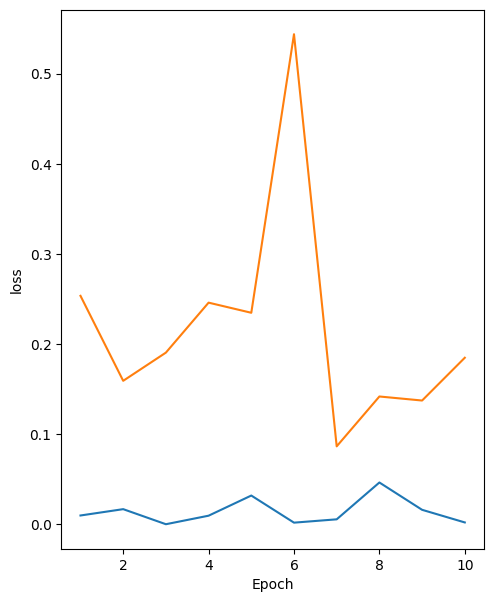

In [125]:
# Plotting the curve

epoch_range = range(1, epochs +1)

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.plot(epoch_range, training_loss_array)
plt.plot(epoch_range, testing_loss_array)
plt.xlabel("Epoch")
plt.ylabel("loss")

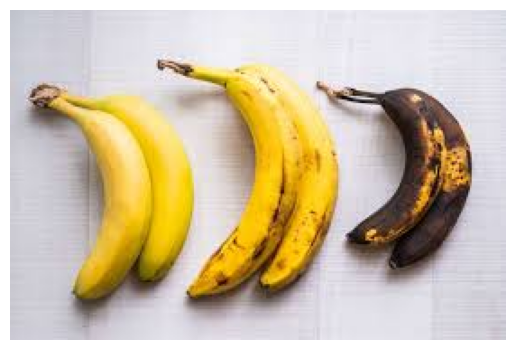

1
0
{'Apple': 0, 'Banana': 1, 'Strawberry': 2}
{'Fresh': 0, 'Rotten': 1}
Prediction Results
------------------
Fruit      : Banana
Freshness  : Fresh


In [142]:
from torchvision import transforms

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



import torch
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def predict_image_from_url(
    image_url,
    model,
    device,
    fruit_lookup,
    freshness_lookup
):
    model.eval()

    # Download image
    response = requests.get(image_url)
    # img = Image.open(BytesIO(response.content)).convert("RGB")
    image_path = "/content/download.jpg"
    img = Image.open(image_path).convert("RGB")


    # Show image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Transform
    img_tensor = inference_transform(img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        fruit_logits, freshness_logits = model(img_tensor)

        fruit_pred = torch.argmax(fruit_logits, dim=1).item()
        freshness_pred = torch.argmax(freshness_logits, dim=1).item()

    # Decode labels
    print(fruit_pred)
    print(freshness_pred)
    print(fruit_to_idx)
    print(freshness_to_idx)
    # fruit_label = fruit_to_idx[fruit_pred]
    # freshness_label = freshness_to_idx[freshness_pred]
    # fruit_label = fruit_to_idx.get_vocabulary()[fruit_pred]
    # Suppose model output is 1 for Apple
    fruit_label = list(fruit_to_idx.keys())[list(fruit_to_idx.values()).index(fruit_pred)]
    freshness_label = list(freshness_to_idx.keys())[list(freshness_to_idx.values()).index(freshness_pred)]

    # freshness_label = freshness_lookup.get_vocabulary()[freshness_pred]

    print("Prediction Results")
    print("------------------")
    print(f"Fruit      : {fruit_label}")
    print(f"Freshness  : {freshness_label}")



image_url = "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg"

predict_image_from_url(
    image_url=image_url,
    model=model,
    device=device,
    fruit_lookup=fruit_lookup,
    freshness_lookup=freshness_lookup
)
